In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import pickle
from sklearn.preprocessing import PowerTransformer


In [2]:
# загружаем матрицу расстояний

with open('data/dist_dict.pickle', 'rb') as handle:
    dist_dict = pickle.load(handle)

In [3]:
df = pd.read_csv('data/full_ds.csv')
df.head()

,pdb,L_chain,H_chain,AG_chain,L_sequence_missing,H_sequence_missing,AG_sequence,L_paratope,H_paratope,AG_L_epitope,AG_H_epitope,L_domain,H_domain,L_y,H_y,H_sequence,L_sequence
0,5js9,B,A,C,***LTQPPSASGSPGQSITISCTGTSNNFVSWYQQHAGKAPKLVIY...,*PQLQESGPTLVEASETLSLTCAVSGDSTAACNSFWGWVRQPPGKG...,NLWVTVYYGVPVWKDAETTLFCASDAKAYETEKHNVWATHACVPTD...,----------------------------------------------...,-------------------------------A--------------...,----------------------------------------------...,----------------------------------------------...,0000000000000000000000111111111222222222222222...,0000000000000000000000000111111111222222222222...,0,42,QPQLQESGPTLVEASETLSLTCAVSGDSTAACNSFWGWVRQPPGKG...,QSALTQPPSASGSPGQSITISCTGTSNNFVSWYQQHAGKAPKLVIY...
1,7su1,L,H,C,EIVLTQSPGTLSLSPGERATLSCRASQEVGESELAWYQQKPGQAPR...,*VQLVESGGGVVQPGRSLRLSCAASGFTFSHYTMHWVRQAPGKGLE...,AMHVAQPAVVLASSRGIASFVCEYASPGKATEVRVTVLRQADSQVT...,---------------------------A----B-------------...,----------------------------------------------...,AB--------------------------------------------...,-------------------------------B-A---C------C-...,0000000000000000000000011111111111122222222222...,0000000000000000000000000111111122222222222222...,34,14,QVQLVESGGGVVQPGRSLRLSCAASGFTFSHYTMHWVRQAPGKGLE...,EIVLTQSPGTLSLSPGERATLSCRASQEVGESELAWYQQKPGQAPR...
2,7su0,M,I,D,EIVLTQSPGTLSLSPGERATLSCRASQEVGESELAWYQQKPGQAPR...,*VQLVESGGGVVQPGRSLRLSCAASGFTFSHYTMHWVRQAPGKGLE...,AMHVAQPAVVLASSRGIASFVCEYASPGKATEVRVTVLRQADSQVT...,-----------------------------AA-B-------------...,------------------------------A---------------...,AAA---------------------------------------CC--...,-------------------------------B-A---C------A-...,0000000000000000000000011111111111122222222222...,0000000000000000000000000111111122222222222222...,42,62,QVQLVESGGGVVQPGRSLRLSCAASGFTFSHYTMHWVRQAPGKGLE...,EIVLTQSPGTLSLSPGERATLSCRASQEVGESELAWYQQKPGQAPR...
3,7su0,L,H,C,EIVLTQSPGTLSLSPGERATLSCRASQEVGESELAWYQQKPGQAPR...,*VQLVESGGGVVQPGRSLRLSCAASGFTFSHYTMHWVRQAPGKGLE...,AMHVAQPAVVLASSRGIASFVCEYASPGKATEVRVTVLRQADSQVT...,---------------------------A--B-B-------------...,------------------------------A---------------...,ABBB------------------------------------------...,-------------------------------C-A---A-A----AA...,0000000000000000000000011111111111122222222222...,0000000000000000000000000111111122222222222222...,34,62,QVQLVESGGGVVQPGRSLRLSCAASGFTFSHYTMHWVRQAPGKGLE...,EIVLTQSPGTLSLSPGERATLSCRASQEVGESELAWYQQKPGQAPR...
4,6q20,L,H,A,DIQLTQSPSFLSASVGDRVTITCRASQDISSYLAWYQQKPGNAPKL...,EVQLVESGGRVVRPGGSLRLSCAASGFTFDDYGMSWVRQPPGKGLE...,VEYRNWSKPQCQITGFAPFSKDNSIRLSAGGDIWVTREPYVSCDPG...,------------------------------A---------------...,------------------------------A---------------...,----------------------------------------------...,------------------------------------DD--------...,0000000000000000000000011111111111222222222222...,0000000000000000000000000111111122222222222222...,40,42,EVQLVESGGRVVRPGGSLRLSCAASGFTFDDYGMSWVRQPPGKGLE...,DIQLTQSPSFLSASVGDRVTITCRASQDISSYLAWYQQKPGNAPKL...


In [4]:
def func(row, dist_dict, is_heavy=True, k=10, dom_id=5):
    """
    Возвращает top-k расстояний из домена dom_id

    dom_id == 0 => FR1
    dom_id == 1 => CDR1
    dom_id == 2 => FR2
    dom_id == 3 => CDR2
    dom_id == 4 => FR3
    dom_id == 5 => CDR3
    dom_id == 6 => FR4

    """
    pdb_id = row.pdb
    if is_heavy:
        chain_id = row.H_chain
        seq = row.H_sequence_missing
        dom = row.H_domain
    else:
        chain_id = row.L_chain
        seq = row.L_sequence_missing
        dom = row.L_domain
    dl = len(seq) - len(seq.strip('*'))
    dom_flags = np.array(list(dom[dl:])).astype(int) == dom_id
    dom_dist_matr = dist_dict[pdb_id][chain_id][dom_flags, :][:, dom_flags]
    top_k = np.partition(np.triu(dom_dist_matr, 1).flatten(), -k)[-k:]
    top_k = np.sort(top_k)
    return top_k


# Кластеризация тяжелых цепей

In [5]:
# находим top-k расстояний для CDR1, CDR2, CDR3 для тяжелой цепи. Скейлим их.

scaler = PowerTransformer

cdr1h = df.apply(lambda row: func(row, dist_dict, k=4, dom_id=1), axis=1).values
cdr1h = np.array([list(x) for x in cdr1h])

cdr2h = df.apply(lambda row: func(row, dist_dict, k=4, dom_id=3), axis=1).values
cdr2h = np.array([list(x) for x in cdr2h])

cdr3h = df.apply(lambda row: func(row, dist_dict, k=4, dom_id=5), axis=1).values
cdr3h = np.array([list(x) for x in cdr3h])

cdrh = np.hstack([cdr1h, cdr2h, cdr3h])

tr = scaler().fit(cdrh)
cdrh = tr.transform(cdrh)


In [6]:
# находим последовательности Framework Region тяжелых цепей

FR_heavy_sequences = df.apply(lambda row: ''.join(np.array(list(row.H_sequence))[np.array(list(row.H_domain)).astype(int) % 2 == 0]), axis=1).values

In [7]:
k = 3  # Choose the length of k-mers
vectorizer = CountVectorizer(analyzer="char", ngram_range=(k, k))
X = vectorizer.fit_transform(FR_heavy_sequences).toarray()

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_seq = pca.fit_transform(X)


# Apply TSNE for dimensionality reduction
X_str = TSNE(perplexity=50, n_iter=50000, n_jobs=-1).fit_transform(cdrh)

c:\Users\langley\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0.98, 'Тяжелые цепи')

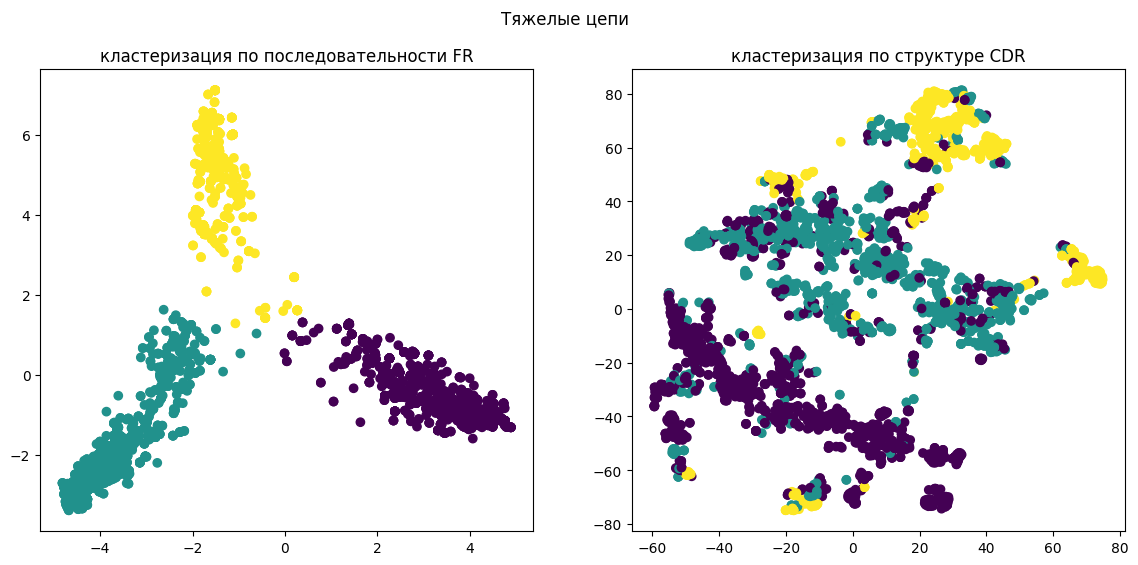

In [8]:
# Cluster the sequences using K-means
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(X_seq)

# Visualize the clusters
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].set(title='кластеризация по последовательности FR')
axs[1].set(title='кластеризация по структуре CDR')
axs[0].scatter(X_seq[:, 0], X_seq[:, 1], c=labels, cmap="viridis")
axs[1].scatter(X_str[:, 0], X_str[:, 1], c=labels, cmap="viridis")
fig.suptitle('Тяжелые цепи')

Text(0.5, 0.98, 'Тяжелые цепи')

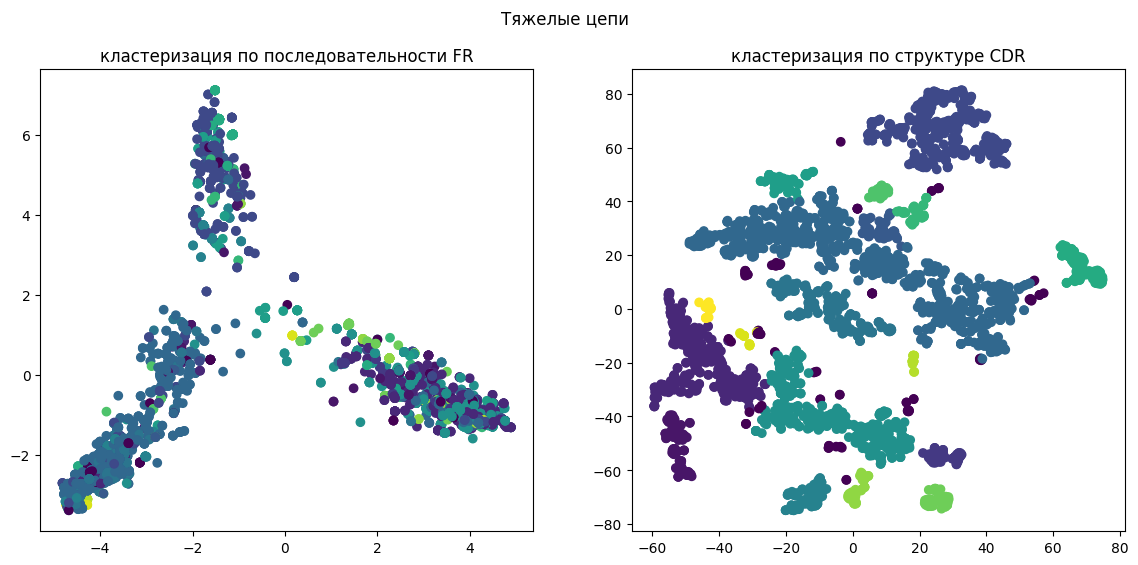

In [9]:
# Cluster the sequences using DBSCAN
db = DBSCAN(eps=4, min_samples=15)
labels = db.fit_predict(X_str)

# Visualize the clusters
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].set(title='кластеризация по последовательности FR')
axs[1].set(title='кластеризация по структуре CDR')
axs[0].scatter(X_seq[:, 0], X_seq[:, 1], c=labels, cmap="viridis")
axs[1].scatter(X_str[:, 0], X_str[:, 1], c=labels, cmap="viridis")
fig.suptitle('Тяжелые цепи')

# Кластеризация легких цепей

In [10]:
# находим top-k расстояний для CDR1, CDR2, CDR3 для легкой цепи. Скейлим их.

scaler = PowerTransformer

cdr1l = df.apply(lambda row: func(row, dist_dict, k=4, dom_id=1, is_heavy=False), axis=1).values
cdr1l = np.array([list(x) for x in cdr1l])

cdr2l = df.apply(lambda row: func(row, dist_dict, k=4, dom_id=3, is_heavy=False), axis=1).values
cdr2l = np.array([list(x) for x in cdr2l])

cdr3l = df.apply(lambda row: func(row, dist_dict, k=4, dom_id=5, is_heavy=False), axis=1).values
cdr3l = np.array([list(x) for x in cdr3l])

cdrl = np.hstack([cdr1l, cdr2l, cdr3l])

tr = scaler().fit(cdrl)
cdrl = tr.transform(cdrl)

In [11]:
# находим последовательности Framework Region легких цепей

FR_light_sequences = df.apply(lambda row: ''.join(np.array(list(row.L_sequence))[np.array(list(row.L_domain)).astype(int) % 2 == 0]), axis=1).values

In [12]:
k = 4  # Choose the length of k-mers
vectorizer = CountVectorizer(analyzer="char", ngram_range=(k, k))
X = vectorizer.fit_transform(FR_light_sequences).toarray()

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_seq = pca.fit_transform(X)

# Apply TSNE for dimensionality reduction
X_str = TSNE(perplexity=50, n_iter=50000, n_jobs=-1).fit_transform(cdrl)

c:\Users\langley\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0.98, 'Легкие цепи')

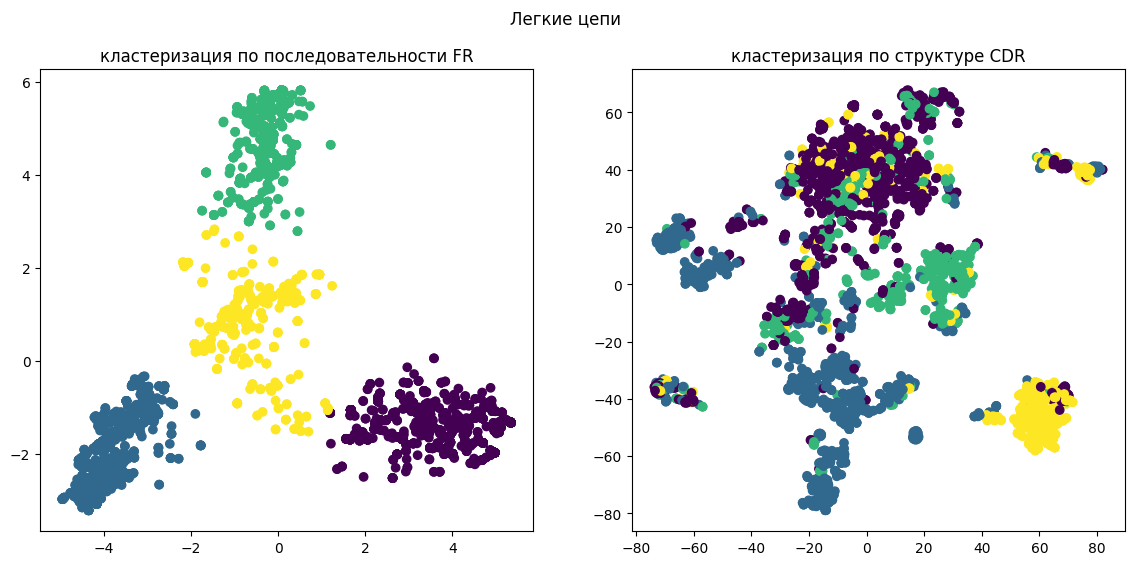

In [13]:
# Cluster the sequences using K-means
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(X_seq)

# Visualize the clusters
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].set(title='кластеризация по последовательности FR')
axs[1].set(title='кластеризация по структуре CDR')
axs[0].scatter(X_seq[:, 0], X_seq[:, 1], c=labels, cmap="viridis")
axs[1].scatter(X_str[:, 0], X_str[:, 1], c=labels, cmap="viridis")
fig.suptitle('Легкие цепи')

Text(0.5, 0.98, 'Легкие цепи')

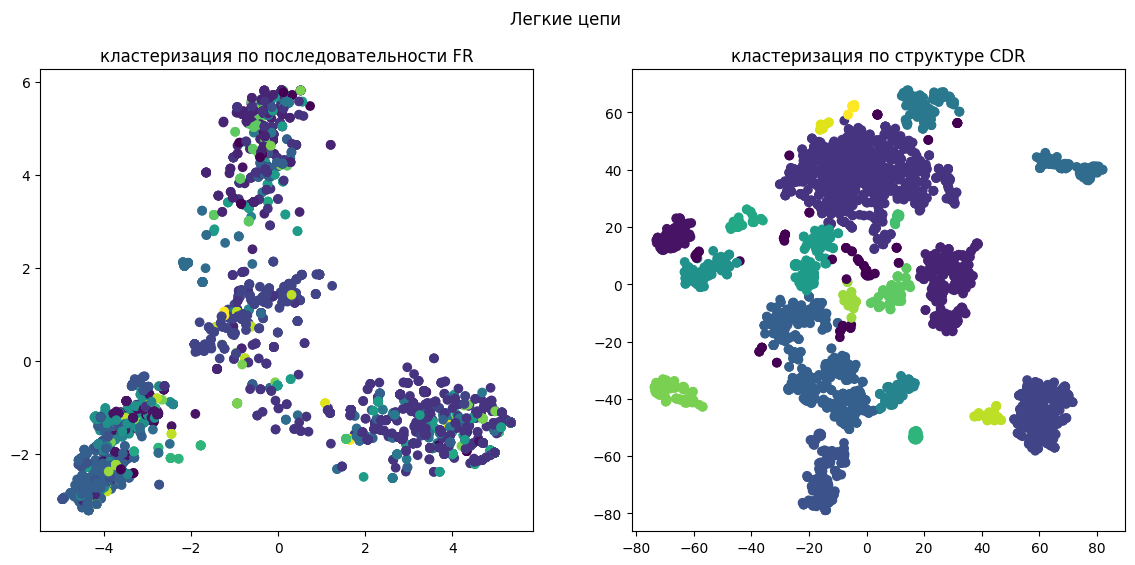

In [14]:
# Cluster the sequences using DBSCAN
db = DBSCAN(eps=4, min_samples=15)
labels = db.fit_predict(X_str)

# Visualize the clusters
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].set(title='кластеризация по последовательности FR')
axs[1].set(title='кластеризация по структуре CDR')
axs[0].scatter(X_seq[:, 0], X_seq[:, 1], c=labels, cmap="viridis")
axs[1].scatter(X_str[:, 0], X_str[:, 1], c=labels, cmap="viridis")
fig.suptitle('Легкие цепи')